# Spring-Slider Element Tutorial

In this tutorial, we demonstrate how to simulate a spring-slider system using different numerical integration methods. We will:
  
- Define the system parameters (mass, stiffness, damping, friction, etc.).
- Set up the ordinary differential equation (ODE) model for the spring-slider.
- Solve the ODE using SciPy's BDF method as well as custom non-smooth solvers (VI and semismooth Newton) from our `Solve_IVP_NS` module.
- Compare the numerical solutions with an analytical solution (provided by a function `piecewise_coulomb`).
- Visualize the results and compare runtimes.



# Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

# Import your custom solver module.
# Replace the following import with the actual location of Solve_IVP_NS.
# For example, if your module is in the same directory, you might do:
# from Solve_IVP_NS import solve_ivp_ns
import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH

# If you have an analytical solution function, import or define it.
# For this tutorial, we assume piecewise_coulomb is defined elsewhere.
from analytical import solve_damped_constant_offset, piecewise_coulomb


# Physical parameters

In [2]:
# Physical parameters
mass = 2.0       # Slider mass [kg]
k = 1.0          # Spring stiffness [N/m]
zeta = 0.0       # Damping ratio
N = 1.0          # Normal force [N]  NOTE: TO PERFORM NONCONSTRAINED SIMULATION SET TO ZERO
v0 = 0.1         # Initial velocity [m/s]

# Friction parameters
Dc = 0.1         # Critical slip distance [m]
mu_res = 0.2     # Residual friction coefficient
Dmu = 0.0        # Friction coefficient drop NOTE: set to zero to compare with analytical solution

# Numerical parameters 
epsilon = 1e-12  # Regularization parameter for solve_ivp comparison NOTE: eps>1e-12 may not converge 
t_span = (0, 10) # Simulation time window

## System Configuration

In [3]:
I = np.eye(1)
Ma = np.array([[mass]])
K = np.array([[k]])
E = 2 * zeta * K

# Block matrix A: first block for velocities (with mass M), second for displacements (I)
A = np.block([
    [mass,               np.zeros((1, 1)), np.zeros((1, 1)) ],
    [np.zeros((1, 1)),    I, np.zeros((1, 1)) ],
    [np.zeros((1, 1)),   np.zeros((1, 1)), I               ]
])


# Dynamical System

In [4]:
def rhs_regularized(t, y):
    """ODE for BDF solver with regularized friction"""
    n = len(y) // 3
    v = y[:n]
    z = y[n:2*n]
    s = y[2*n:]
    v_dot = ( - K @ s - E @ (v)- friction_force(y))/mass
    return np.concatenate([v_dot, np.array([0]), v])

def rhs(t, y):
    """Smooth rhs (for projection and SSN methods)"""
    n = len(y) // 3
    v = y[:n]
    z = y[n:2*n]
    s = y[2*n:]
    v_dot = - K @ s - E @ (v)
    z_dot = np.zeros(n) # NOTE: this is a dummy variable required for friction. IT MUST FOLLOW DIRECTLY AFTER CONSTRAINED VARIABLE.
    s_dot = v
    return np.concatenate([v_dot, z_dot, s_dot])

# Friction

In [5]:
def regularized_sign(v):
    """Smooth approximation of sign function"""
    return np.tanh(v / epsilon)

def mu(y):
    """Slip-weakening friction law"""
    s = y[2]
    return mu_res * (1 - Dmu/mu_res * np.exp(-abs(s)/Dc))

def friction_force(y):
    """Regularized friction force"""
    v = y[0]
    return mu(y) * N * regularized_sign(v)

def con_force(y):
    """Friction constraint on velocity"""
    constraint = np.zeros_like(y)
    constraint[0] = mu(y) * N
    return constraint


# Solver setup and integration

In [6]:
y0 = np.array([v0, abs(v0), 0.0]) # initial condition. note z is ideally set to be abs() of constrained variable.
component_slices = [slice(0,1), slice(1,2), slice(2,3)] # we may get rid of this or use for other things in the future right now dummy

# projection and solver options
projection_opts = {
    'con_force_func': con_force, # pass the friction constraint force
    'rhok': np.array([1.0, 1.0, 1.0]), #kind of a dummy operation, may remove but for now required
    'component_slices': component_slices, #ditto
    'constraint_indices': [0] # index (or indices) of the constrained variable
}
solver_opts = {
    'tol': 1e-10,
    'max_iter': 100,
}


# ============== Solve with Projected Gradient ==============
tic_vi = time.time()
t_vals_vi, y_vals_vi, h_vals_vi, fk_vals_vi, solver_info_vi = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite', #integration method: for others see documentation
    projection='coulomb',
    solver='VI', #we need to rename
    projection_opts=projection_opts,
    solver_opts=solver_opts,
    adaptive=True,
    atol=1e-6,
    rtol=1e-3,
    h0=0.01, # initial time step
    component_slices=component_slices,
    verbose=False,
    A=A
)
print('Solve with PG succesful')
toc_vi = time.time() - tic_vi


# ============== Solve with semismooth_newton ==============
solver_opts_ssn = solver_opts.copy()
solver_opts_ssn['max_iter'] = 100 #for example we can modify options if needed
tic_ssn = time.time()
t_vals_ssn, y_vals_ssn, h_vals_ssn, fk_vals_ssn, solver_info_ssn = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='semismooth_newton',
    projection_opts=projection_opts,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    atol=1e-6,
    rtol=1e-3,
    h0=0.01, 
    component_slices=component_slices,
    verbose=False,
    A=A
)
print('Solve with SSN succesful')
toc_ssn = time.time() - tic_ssn


# ============== Solve with BDF ==============
tic_bdf = time.time()
sol_bdf = solve_ivp(rhs_regularized, t_span, y0, method='BDF',
                    atol=1e-6, rtol=1e-3)
toc_bdf = time.time() - tic_bdf


# Runtime comparison
print(f"Runtime Comparison:\n"
        f"VI: {toc_vi:.3f} sec\n"
        f"SSN: {toc_ssn:.3f} sec\n"
        f"BDF: {toc_bdf:.3f} sec")

Solve with PG succesful
Solve with SSN succesful
Runtime Comparison:
VI: 0.240 sec
SSN: 0.044 sec
BDF: 0.066 sec


/home/david/Desktop/NS_integration/myproject/Solve_IVP_NS/projections.py:254: UserWarning: Autodiff Jacobian evaluation failed: loop of ufunc does not support argument 0 of type ArrayBox which has no callable exp method. Using numerical from now on.
  warnings.warn(f"Autodiff Jacobian evaluation failed: {e}. Using numerical from now on.")


# Post processing

In [7]:
def get_acceleration_ns(t_vals, y_vals, fk_vals):
    # Evaluate the ODE at each time-step
    rhs_values = np.array([rhs(t, y) for t,y in zip(t_vals, y_vals)])

    F = rhs_values[1:] + fk_vals 

    Ainv = np.linalg.inv(A)

    acc_array = F @ Ainv
    return acc_array


def get_acceleration_sivp(t_vals, y_vals):
    # Evaluate the ODE at each time-step => shape (N,3).
    rhs_values = np.array([rhs_regularized(t, y) for t,y in zip(t_vals, y_vals)])
    # We only want the last N-1 rows (to align with t_vals[1:]).

    return  rhs_values[:,0]



acc_solv_ivp = get_acceleration_sivp(sol_bdf.t, sol_bdf.y.T)
acc_vi = get_acceleration_ns(t_vals_vi, y_vals_vi, fk_vals_vi)
acc_ssn = get_acceleration_ns(t_vals_ssn, y_vals_ssn, fk_vals_ssn)

# Analytical Solution

In [8]:
# Call piecewise_coulomb with matching t_end(same as your t_span)
# so you can compare them directly.  E.g.:
c_val = 2.0 * zeta * K[0,0]  
k_val = K[0,0]
t_ana, s_ana, v_ana, a_ana = piecewise_coulomb(
    m=mass, 
    c=c_val,
    k=k_val,
    mu_res=mu_res,
    s0=0.0,
    v0=v0,
    t_end=t_span[1],
    n_steps=300
)

# Plotting

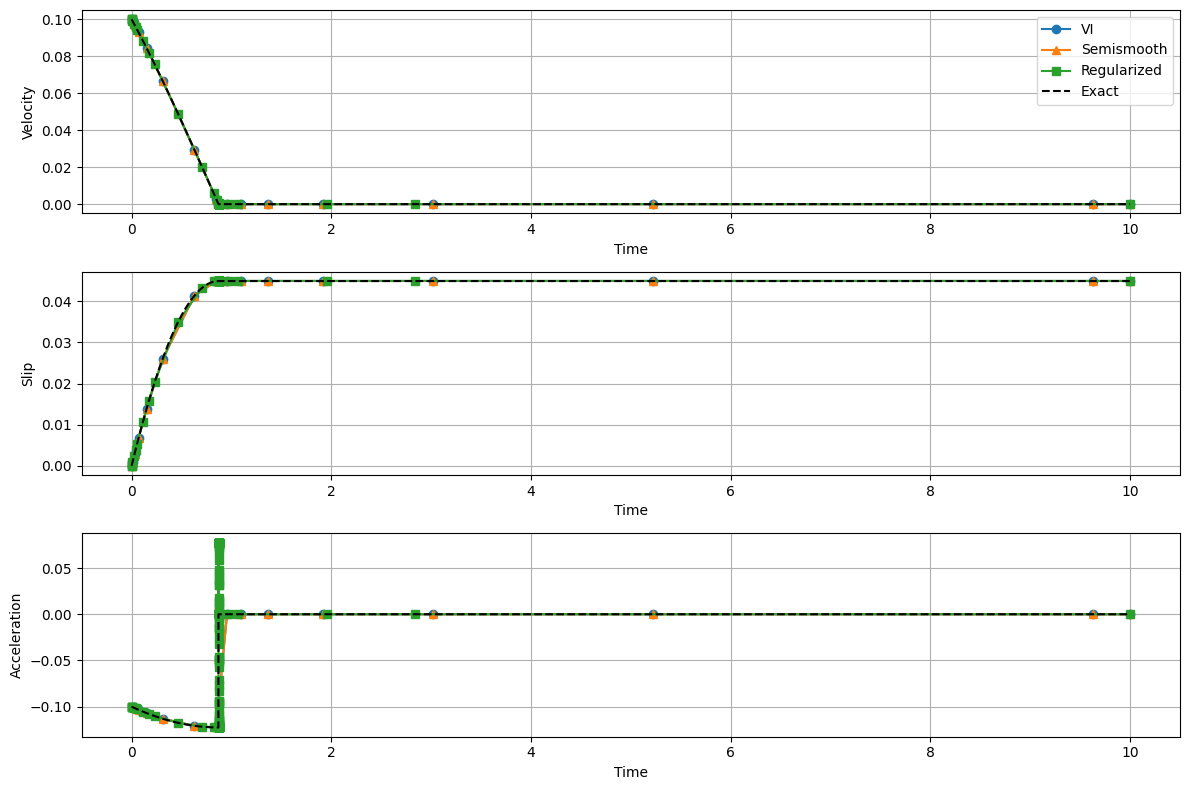

In [9]:
# ============== Plotting ==============
plt.figure(figsize=(12, 8))

# Velocity plot
plt.subplot(3,1,1)
plt.plot(t_vals_vi, y_vals_vi[:,0], "o-", label="VI")
plt.plot(t_vals_ssn, y_vals_ssn[:,0], "^-", label="Semismooth")
plt.plot(sol_bdf.t, sol_bdf.y[0], "s-", label="Regularized")
plt.plot(t_ana, v_ana, "k--", label="Exact")
plt.legend()
plt.grid()
plt.xlabel("Time")
plt.ylabel("Velocity")

# Slip plot
plt.subplot(3,1,2)
plt.plot(t_vals_vi, y_vals_vi[:,2], "o-")
plt.plot(t_vals_ssn, y_vals_ssn[:,2], "^-")
plt.plot(sol_bdf.t, sol_bdf.y[2], "s-")
plt.plot(t_ana, s_ana, "k--")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Slip")

# Acceleration plot
plt.subplot(3,1,3)
plt.plot(t_vals_vi[1:], acc_vi[:,0], "o-")
plt.plot(t_vals_ssn[1:], acc_ssn[:,0], "^-")
plt.plot(sol_bdf.t,acc_solv_ivp, "s-")
plt.plot(t_ana,a_ana, "k--")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.tight_layout()
plt.show()

